# Every Person Is Different

1. Each person is different. We showed this previously (Lim YW, Schmieder R, Haynes M, Willner D, Furlan M, Youle M, Abbott K, Edwards R, Evangelista J, Conrad D, Rohwer F. 2013. Metagenomics and metatranscriptomics: windows on CF-associated viral and microbial communities. J Cyst Fibros 12:154–164) and I think Katrine and others have followed this up a lot, so it’s not that interesting a story arc, but needs commenting on.

  a. There may be individual differences but also some microbiome generalizations based on: 

        i. pancreatic sufficiency vs insufficiency - see Jupyter/pancreatic sufficiency.ipynb
        
        ii. CF related diabetes/pre-diabetes/no diabetes
        
        iii. Age (we know that diversity tends to drop with age/declining lung function/increasing treatment)
        
        iv. Gender


In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read the data frames 

We also correct the names

In [2]:
corrections = {
    "MGI" : { 
        '1112926_20171212_S' : '1447437_20171212_S',
        '1128691_20170206_S' : '1128691_20171206_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '1723809_20180227_S' : '1085876_20180227_S',
        '649354_20170206_S' : '639354_20171206_S',
        '652927_20180226_S' : '715927_20180226_S',
        '658355_20180301_S' : '658355_20180327_S',
        '777851_20170918_S' : '778851_20170918_S',
        '788707_20181126_S' : '788707_20181129_S'
    },
    "minion" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '698917_20190119_S' : '698917_20180119_S'
        }
}

def read_taxonomy(tax_file, firstchar, sequence_type):
    """
    Read the taxonomy file and return a data frame
    """
    
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None
       
    df = pd.read_csv(tax_file, sep='\t', compression='gzip')
    df = df[df['taxonomy'].str.contains('k__Bacteria')]
    df = df[~df['taxonomy'].str.endswith(f'{firstchar}__')]
    df = df.set_index('taxonomy')
    df = df.rename(columns=corrections[sequence_type])
    df.index = df.index.str.split(';').str[-1]
    df = df.sort_index(axis=1)
    return df

def read_metadata(sequence_type):
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None
    
    metadata = pd.read_csv("../Metadata/Metadata.txt", encoding='windows-1252', sep="\t", index_col=0)
    metadata = metadata[~metadata[sequence_type].isna()]

    for ix in metadata.index:
        s = metadata.loc[ix, sequence_type]
        if s in corrections[sequence_type]:
            metadata.loc[ix, sequence_type] = corrections[sequence_type][s]
    return metadata

def sorted_presence_absence(df1, df2, minrowsum=0, asc_sort=False):
    """
    Join the two tables and return the sorted version
    """
    # filter so we only include samples sequenced on both MGI and MinION
    common_columns = df1.columns.intersection(df2.columns)
    df1_both = df1[common_columns]
    df2_both = df2[common_columns]
    
    # create a presence/absence matrix
    df1_presence = (df1_both > 0).astype(int)
    df2_presence = (df2_both > 0).astype(int)*2

    # here we filter on the minimum number of columns each taxa is in if requested
    if minrowsum > 0:
        df1_presence = df1_presence.loc[df1_presence[df1_presence.sum(axis=1) > minrowsum].index]
        df2_presence = df2_presence.loc[df2_presence[df2_presence.sum(axis=1) > (2 * minrowsum)].index]
    
    # combine the two matrices and sort them
    both = df1_presence.add(df2_presence, fill_value=0)
    sboth = both.loc[both.sum(axis=1).sort_values(ascending=asc_sort).index]
    sboth = sboth.sort_index(axis=1) # sort by column names

    return sboth

In [3]:
tax='genus'
# read the data 
mgi_df = read_taxonomy(f"../MGI/Taxonomy/MGI_reads_{tax}.normalised.tsv.gz", tax[0], "mgi")
min_df = read_taxonomy(f"../MinION/Taxonomy/Minion_read_based_annotations_{tax}.normalised.tsv.gz", tax[0], "minion")
mgi_metadata = read_metadata("MGI")
minion_metadata = read_metadata("minion")

### Selecting MGI data

In [4]:
sequence_type = "MGI"
# sequence_type = "minion"

if sequence_type == "MGI":
    df = mgi_df.T
    metadata = mgi_metadata
else:
    df = min_df.T
    metadata = minion_metadata

metadata = metadata[~metadata[sequence_type].isna()]

## Choosing some colours and markers

There are 62 people! It will never work

In [5]:
# Create a color palette with distinct colors for each person
colours = sns.color_palette("Set3", 12) * 6  # Repeating the Set3 palette to cover 62 unique people
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H', 'X', 'P', '+', 'x']  # A list of markers
marker_cycle = cycle(markers)  # Cycle through the marker types


In [6]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()


explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

In [7]:
pca_df

,PC1,PC2
1068841_20180306_S,139.620088,-17.815243
1085876_20180227_S,128.648962,-97.599067
1128691_20171206_S,-328.588342,-140.399465
1128691_20171218_S,-322.830029,-161.162497
1128691_20180116_S,-392.195153,-124.246353
...,...,...
895293_20180502_S,87.003279,-8.085006
896213_20180427_S,49.256778,82.379745
913873_20180417_S,79.936531,106.471941
980574_20180403_S,72.534680,107.422213


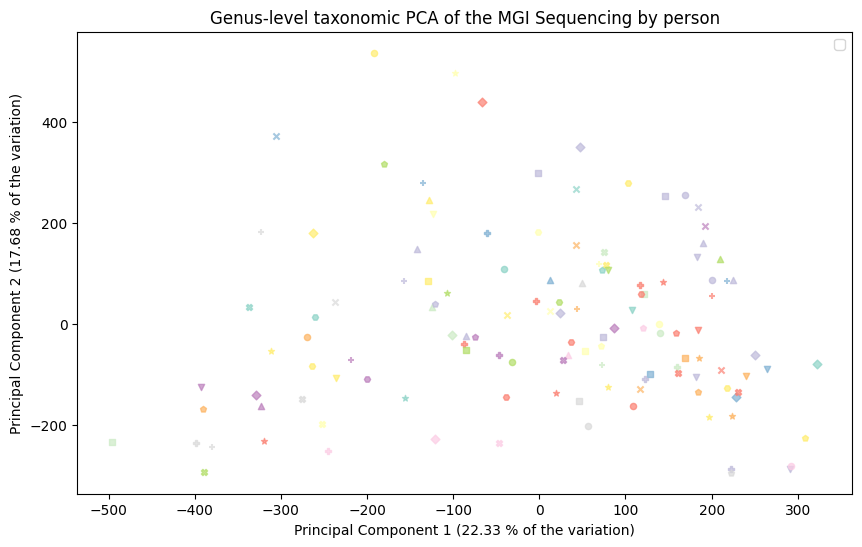

In [8]:
# Plot the PCA with individual markers and colors for each person
plt.figure(figsize=(10, 6))

# create a LUT for the people
person_colour = {}
for idx, person in enumerate(set(metadata.pwCF_ID.values)):
    person_colour[person] = colours[idx]

for idx, MGI in enumerate(pca_df.index):
    person = metadata[metadata["MGI"] == MGI]["pwCF_ID"].values[0]
    
    plt.scatter(pca_df.loc[MGI, 'PC1'], pca_df.loc[MGI, 'PC2'], 
                color=person_colour[person], label=person, 
                marker=next(marker_cycle), s=20, alpha=0.7)


# Add labels and legend
plt.title(f'{tax.capitalize()}-level taxonomic PCA of the MGI Sequencing by person')
plt.xlabel(f'Principal Component 1 ({pc1_variance:.2f} % of the variation)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.2f} % of the variation)')
plt.legend([])
# Display legend with the person labels
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2)

plt.savefig('img/every_person_pca.png')
# Show plot
plt.show()

## Which people do we have more than once?

In [9]:
metadata.groupby(by='pwCF_ID').count().sort_values(by='MGI', ascending=False)

,minion,MGI,Sample date,IP vs OP,Hospital,Room,Age,Age groups,Paediatric vs Adult,Gender,...,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million),Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171
pwCF_ID,,,,,,,,,,,,,,,,,,,,,
788707,4,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,0,0,0,0,0
825012,2,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,0,0,0,0,0
676138,1,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,0,0,0,0
785991,3,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,0,0,0,0
748699,2,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896213,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
913873,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
980574,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0


# Filter the DF for some of the people

In [10]:
interesting_people = list(map(str, metadata.groupby(by='pwCF_ID').count().sort_values(by='MGI', ascending=False).index[0:6]))
interesting_people

['788707', '825012', '676138', '785991', '748699', '658355']

In [11]:
interesing_pwCF = [x for x in mgi_df.columns if x.startswith(tuple(interesting_people))]
interesing_pwCF_df = mgi_df[interesing_pwCF]

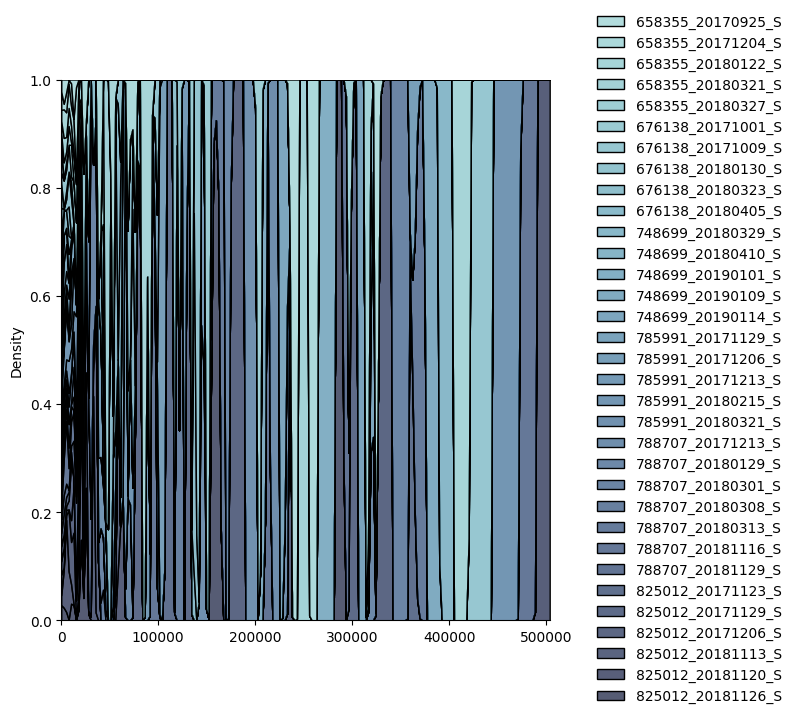

In [12]:
sns.displot(
    data=interesing_pwCF_df.sort_values(by=interesing_pwCF[0]),
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

<Axes: ylabel='taxonomy'>

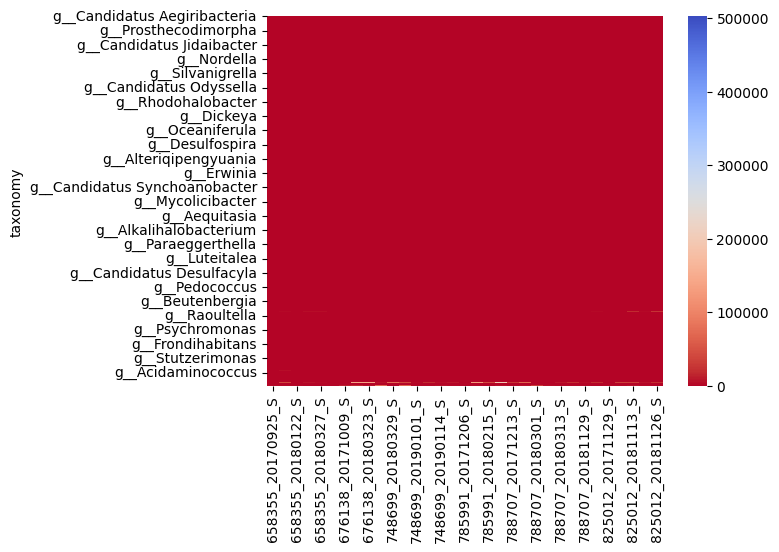

In [13]:
sns.heatmap(
    data=interesing_pwCF_df.sort_values(by=interesing_pwCF[0]),
    cmap='coolwarm_r'
)

# Plot a figure for just one person!

In [14]:
pta = [x for x in mgi_df.columns if x.startswith(interesting_people[0])]
pta_df = mgi_df[pta]
minrowsum = 1000
pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]

## Maybe a ridge plot?

In [15]:

pwCF_ID = interesting_people[0]
pta = [x for x in mgi_df.columns if x.startswith(pwCF_ID)]
pta_df = mgi_df[pta]
minrowsum = 1000
pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]


renames = {x: int(x.replace(f'{pwCF_ID}_', '').replace('_S', '')) for x in pta_df.columns}
pta_df = pta_df.rename(columns=renames)


df_long = pd.melt(pta_df.reset_index(), id_vars='taxonomy', var_name='Date', value_name='Value')
df_long['Date'] = pd.to_datetime(df_long['Date'], format='%Y%m%d')
df_long['Date_Num'] = mdates.date2num(df_long['Date'])
df_long

,taxonomy,Date,Value,Date_Num
0,g__Actinomyces,2017-12-13,7088.364270,17513.0
1,g__Mobiluncus,2017-12-13,120.141767,17513.0
2,g__Schaalia,2017-12-13,2027.392323,17513.0
3,g__Trueperella,2017-12-13,315.372139,17513.0
4,g__Varibaculum,2017-12-13,30.035442,17513.0
...,...,...,...,...
646,g__Haemophilus,2018-11-29,631.633872,17864.0
647,g__Rodentibacter,2018-11-29,157.908468,17864.0
648,g__Pseudomonas,2018-11-29,2543.699452,17864.0
649,g__Vibrio,2018-11-29,178.505225,17864.0


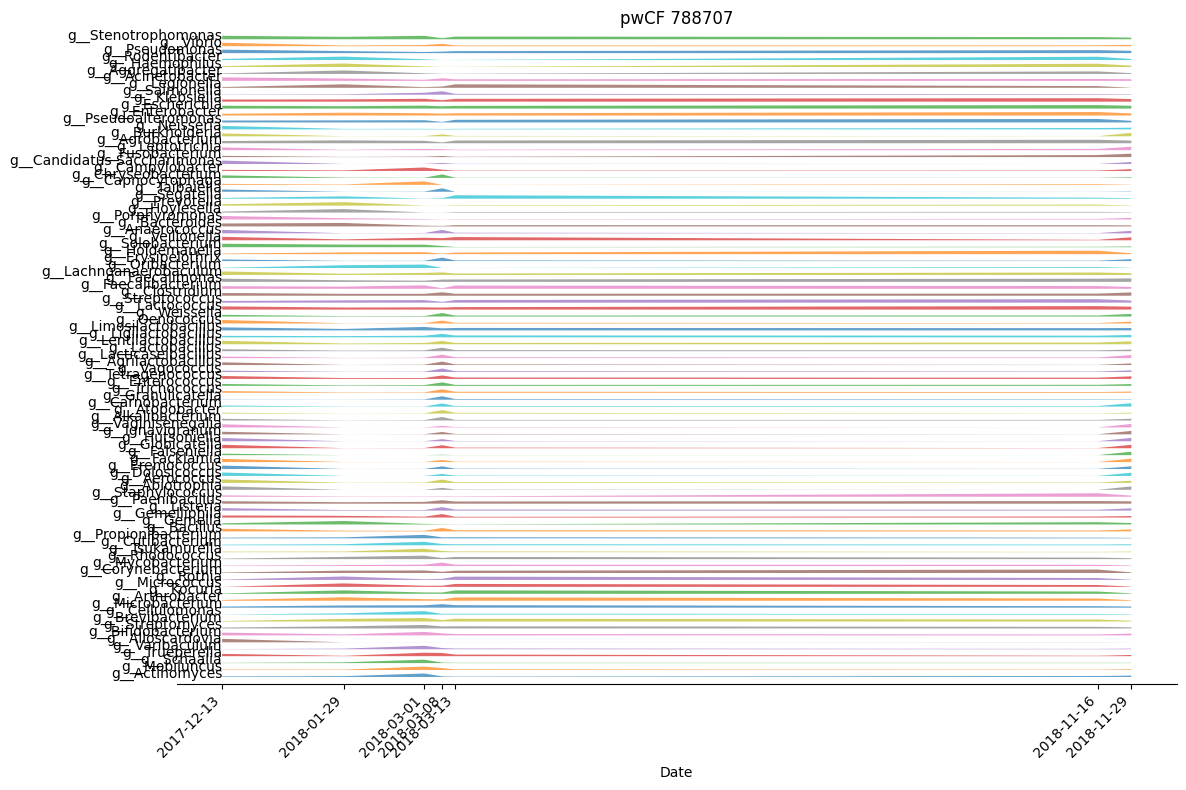

In [16]:
# Get unique bacteria names
bacteria_list = df_long['taxonomy'].unique()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define vertical spacing between ridges
spacing = 2.0

# Plot each bacteria's data
for i, bacteria in enumerate(bacteria_list):
    # Subset the data
    subset = df_long[df_long['taxonomy'] == bacteria]
    # Normalize values for consistent plotting
    values = subset['Value'] / subset['Value'].max()
    # Offset for the ridge
    offset = i * spacing
    # Plot the ridge
    ax.fill_between(subset['Date'], offset, values + offset, alpha=0.7)
    # Add bacteria name
    ax.text(subset['Date'].min(), offset + spacing / 2, bacteria, va='center', ha='right')

# Adjust y-axis limits
ax.set_ylim(-spacing, len(bacteria_list) * spacing)
# Hide y-axis labels
ax.set_yticks([])

date_list = df_long['Date'].unique()
# Set x-axis label
plt.xlabel('Date')
ax.set_xticks(date_list)
plt.xticks(rotation=45, ha='right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.title(f"pwCF {pwCF_ID}")

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


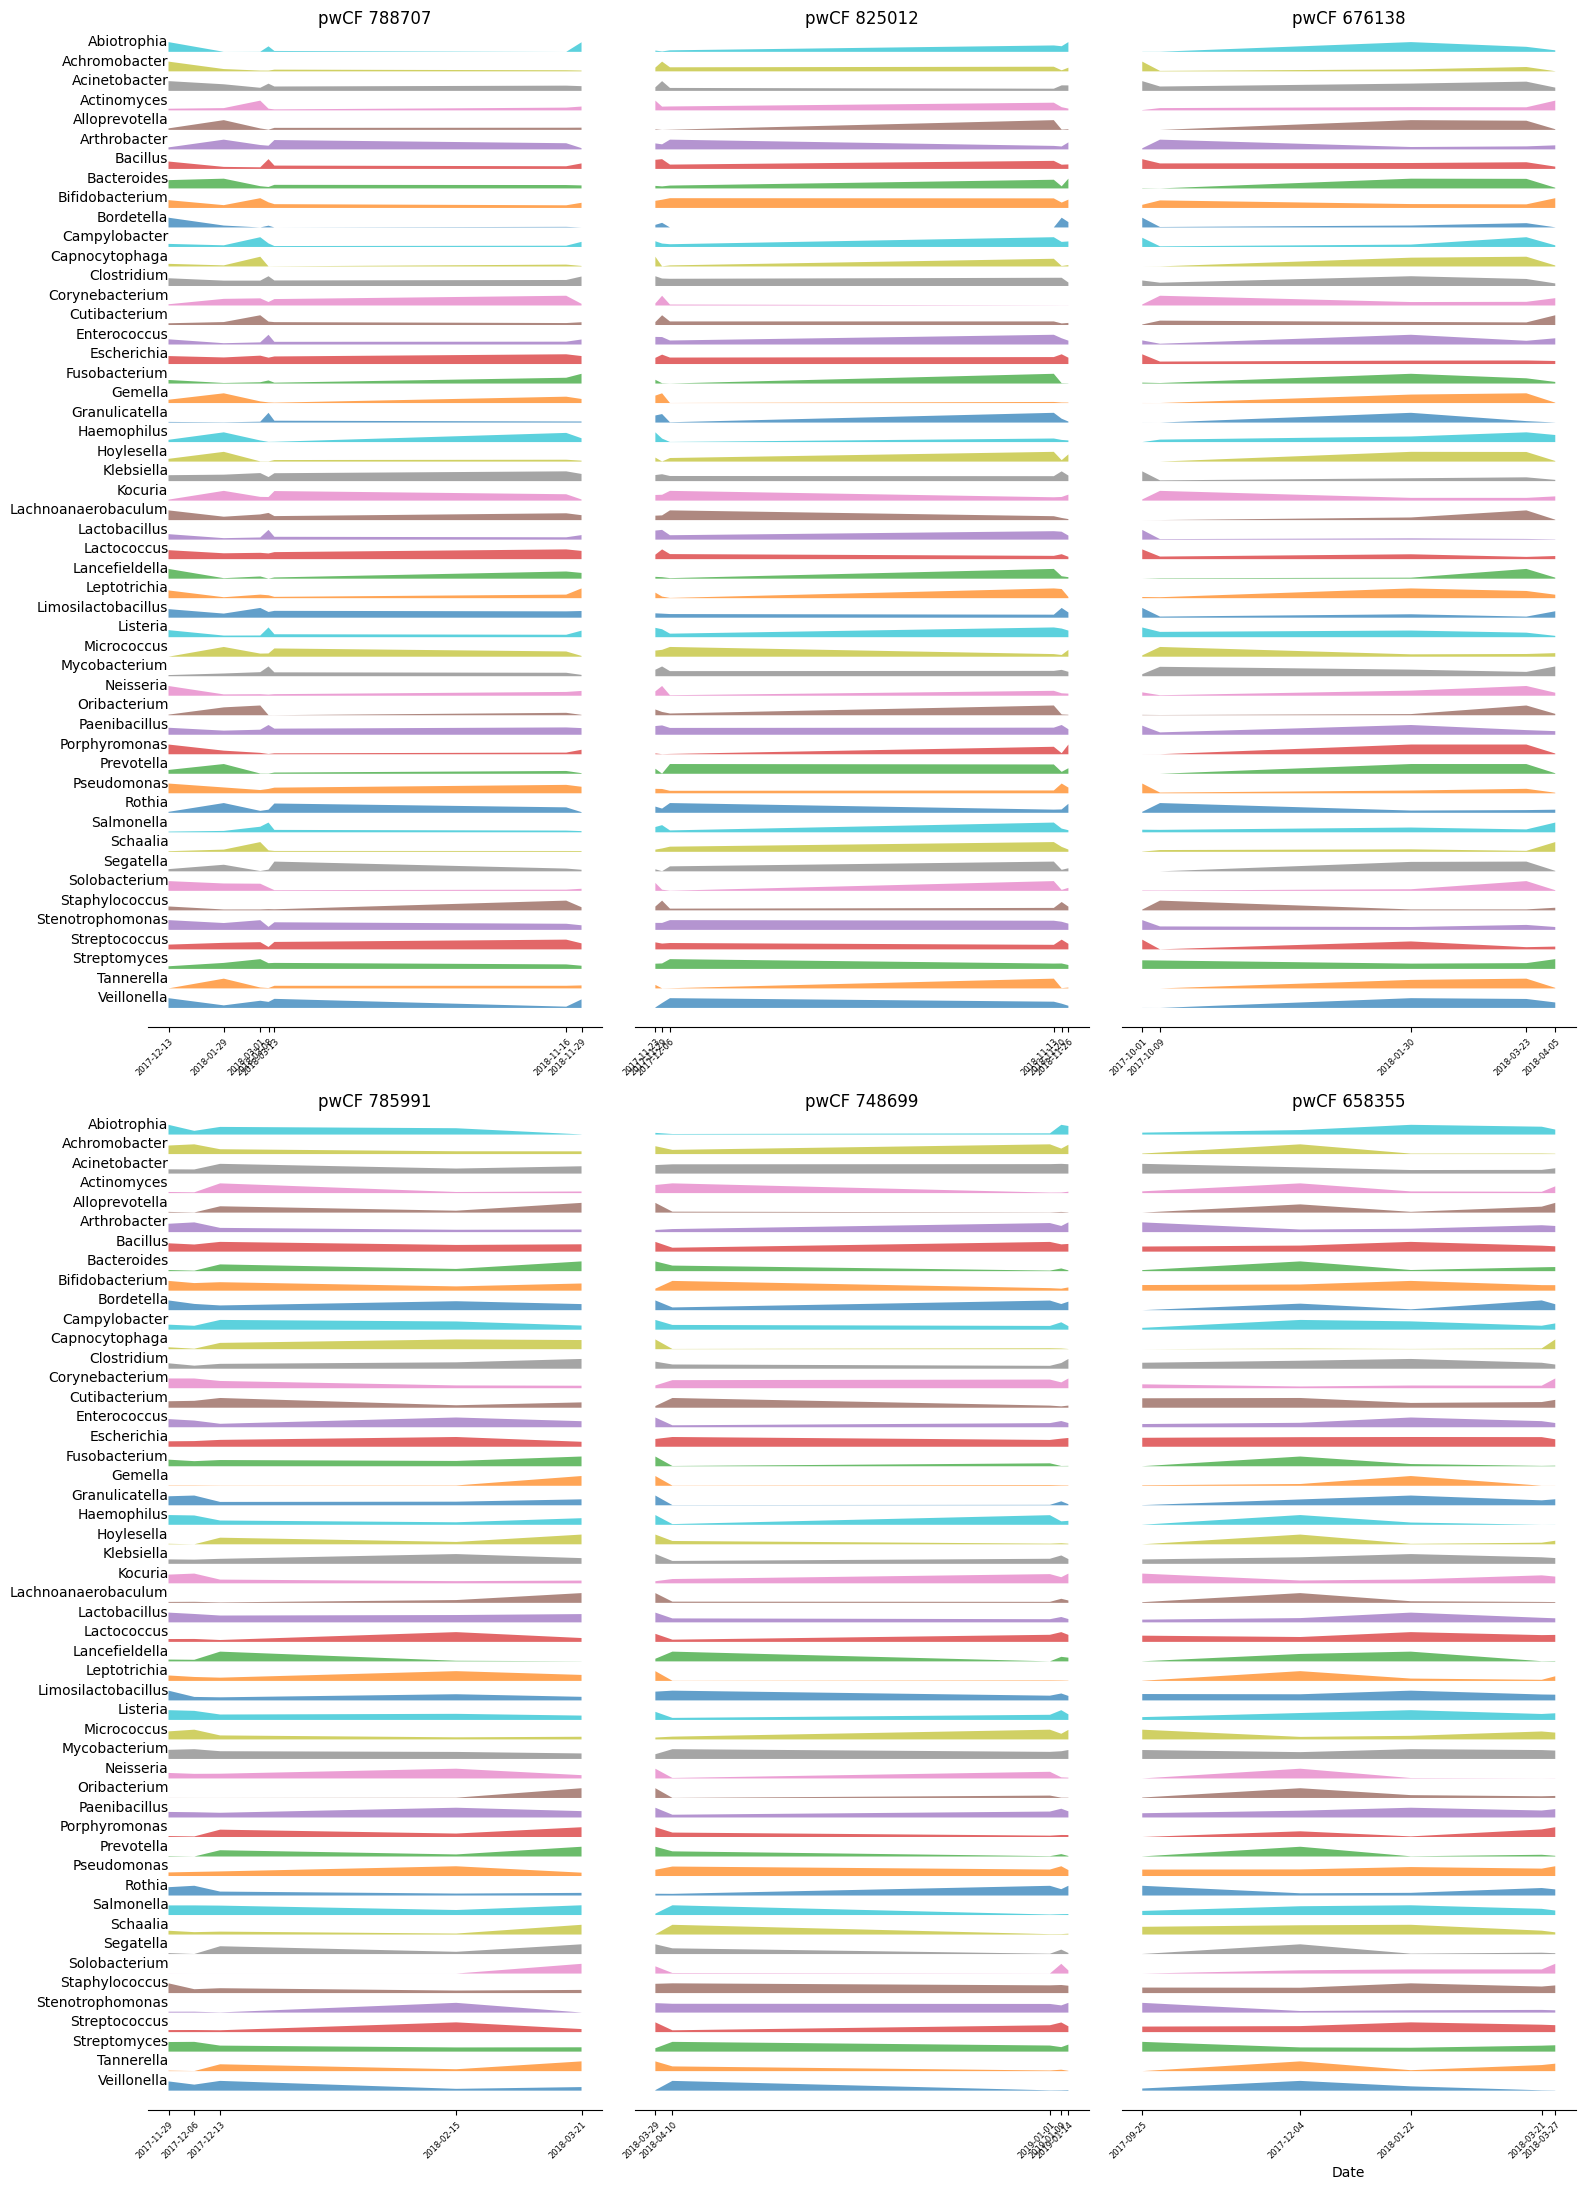

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(16, 22), sharey=True)

# first, we filter out the bacteria to get the top X (currently 50) entries
all_pts = [x for x in mgi_df.columns if any(x.startswith(y) for y in interesting_people)]
pta_df = mgi_df[all_pts]
# find the top 50 row sums
minrowsum = sorted(pta_df.sum(axis=1), reverse=True)[50]
pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]

bacteria_name = {x:x.replace(f"{tax[0]}__", "").replace(" Family ", "_").replace("Candidatus ", "").split(" ")[0] for x in pta_df.index.unique()}
bacteria_name = dict(sorted(bacteria_name.items(), key=lambda item: item[1], reverse=True))
bacteria_list = list(bacteria_name.keys())

row = 0
col = 0
# Get unique bacteria names
for i, pwCF_ID in enumerate(interesting_people):
    
    pta = [x for x in mgi_df.columns if x.startswith(pwCF_ID)]
    pta_df = mgi_df[pta]
    minrowsum = 1000
    #pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]
    renames = {x: int(x.replace(f'{pwCF_ID}_', '').replace('_S', '')) for x in pta_df.columns}
    pta_df = pta_df.rename(columns=renames)

    df_long = pd.melt(pta_df.reset_index(), id_vars='taxonomy', var_name='Date', value_name='Value')
    df_long['Date'] = pd.to_datetime(df_long['Date'], format='%Y%m%d')
    df_long['Date_Num'] = mdates.date2num(df_long['Date'])
    df_long

    

    ax = axes[row][col]

    # Define vertical spacing between ridges
    spacing = 2.0

    # Plot each bacteria's data
    for ix, bacteria in enumerate(bacteria_list):
        # Subset the data
        subset = df_long[df_long['taxonomy'] == bacteria]
        # Normalize values for consistent plotting
        values = subset['Value'] / subset['Value'].max()
        # Offset for the ridge
        offset = ix * spacing
        # Plot the ridge
        ax.fill_between(subset['Date'], offset, values + offset, alpha=0.7)
        # Add bacteria name
        if col == 0:
            ax.text(subset['Date'].min(), offset + spacing / 2, bacteria_name[bacteria], va='center', ha='right')

    # Adjust y-axis limits
    ax.set_ylim(-spacing, len(bacteria_list) * spacing)
    # Hide y-axis labels
    ax.set_yticks([])

    date_list = df_long['Date'].unique()
    # Set x-axis label
    plt.xlabel('Date')
    ax.set_xticks(date_list)
    plt.setp(ax.get_yticklabels(), fontsize=6)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
    """
    for j, label in enumerate(ax.get_xticklabels()):
        if j % 2 == 0:
            label.set_y(0)  # Position below x-axis
        else:
            label.set_visible(False)
    """
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.title.set_text(f"pwCF {pwCF_ID}")  

    if i == 2:
        row = 1
        col = 0
    else:
        col += 1


# Adjust layout
plt.tight_layout()
fig.align_xlabels()
# Display the plot
plt.savefig('img/every_person_is_different_mgi.svg')
plt.savefig('img/every_person_is_different_mgi.png')
plt.show()

    

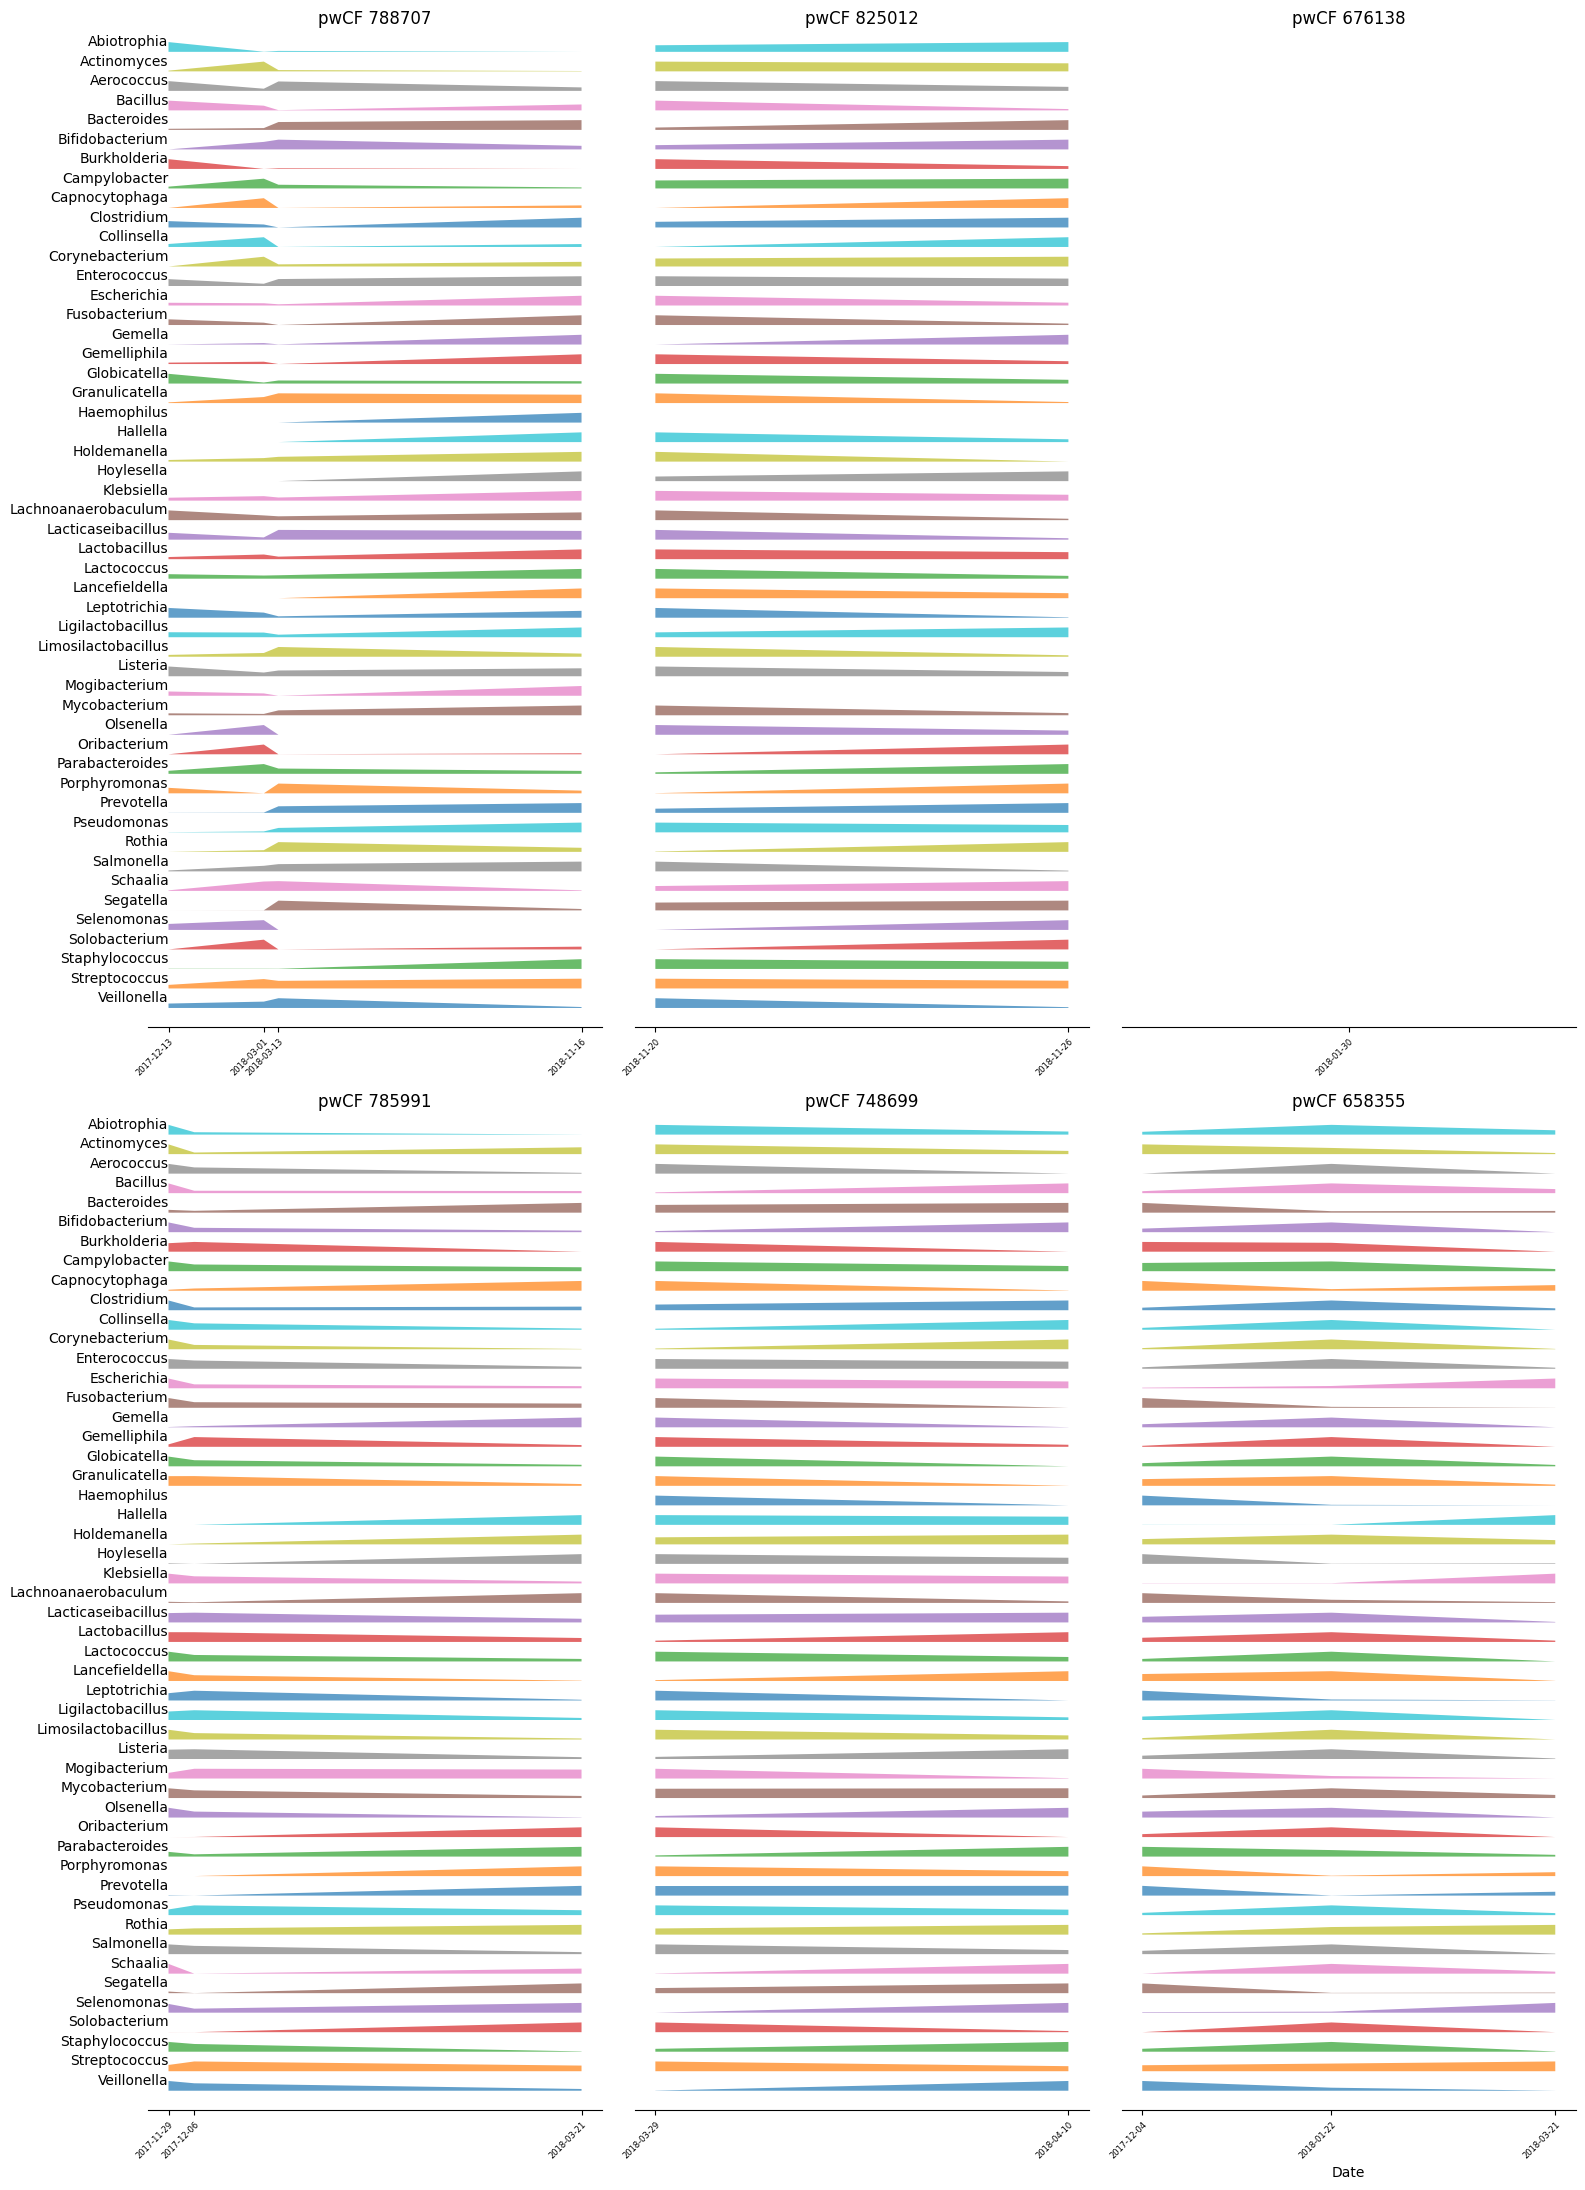

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 22), sharey=True)

# first, we filter out the bacteria to get the top X (currently 50) entries
all_pts = [x for x in min_df.columns if any(x.startswith(y) for y in interesting_people)]
pta_df = min_df[all_pts]
# find the top 50 row sums
minrowsum = sorted(pta_df.sum(axis=1), reverse=True)[50]
pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]

bacteria_name = {x:x.replace(f"{tax[0]}__", "").replace(" Family ", "_").replace("Candidatus ", "").split(" ")[0] for x in pta_df.index.unique()}
bacteria_name = dict(sorted(bacteria_name.items(), key=lambda item: item[1], reverse=True))
bacteria_list = list(bacteria_name.keys())


row = 0
col = 0
# Get unique bacteria names
for i, pwCF_ID in enumerate(interesting_people):
    
    pta = [x for x in min_df.columns if x.startswith(pwCF_ID)]
    pta_df = min_df[pta]
    minrowsum = 1000
    #pta_df = pta_df.loc[pta_df[pta_df.sum(axis=1) > minrowsum].index]
    renames = {x: int(x.replace(f'{pwCF_ID}_', '').replace('_S', '')) for x in pta_df.columns}
    pta_df = pta_df.rename(columns=renames)

    df_long = pd.melt(pta_df.reset_index(), id_vars='taxonomy', var_name='Date', value_name='Value')
    df_long['Date'] = pd.to_datetime(df_long['Date'], format='%Y%m%d')
    df_long['Date_Num'] = mdates.date2num(df_long['Date'])
    df_long

    

    ax = axes[row][col]

    # Define vertical spacing between ridges
    spacing = 2.0

    # Plot each bacteria's data
    for ix, bacteria in enumerate(bacteria_list):
        # Subset the data
        subset = df_long[df_long['taxonomy'] == bacteria]
        # Normalize values for consistent plotting
        values = subset['Value'] / subset['Value'].max()
        # Offset for the ridge
        offset = ix * spacing
        # Plot the ridge
        ax.fill_between(subset['Date'], offset, values + offset, alpha=0.7)
        # Add bacteria name
        if col == 0:
            ax.text(subset['Date'].min(), offset + spacing / 2, bacteria_name[bacteria], va='center', ha='right')

    # Adjust y-axis limits
    ax.set_ylim(-spacing, len(bacteria_list) * spacing)
    # Hide y-axis labels
    ax.set_yticks([])

    date_list = df_long['Date'].unique()
    # Set x-axis label
    plt.xlabel('Date')
    ax.set_xticks(date_list)
    plt.setp(ax.get_yticklabels(), fontsize=6)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
    """
    for j, label in enumerate(ax.get_xticklabels()):
        if j % 2 == 0:
            label.set_y(0)  # Position below x-axis
        else:
            label.set_visible(False)
    """
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.title.set_text(f"pwCF {pwCF_ID}")  

    if i == 2:
        row = 1
        col = 0
    else:
        col += 1


# Adjust layout
plt.tight_layout()
fig.align_xlabels()
# Display the plot
plt.savefig('img/every_person_is_different_minion.png')
plt.show()

    